In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
x = pd.read_csv("BC_Xtrain.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("BC_ytrain.csv").drop(columns=["Unnamed: 0"])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.decomposition import PCA, FastICA
x1 = PCA(n_components=10,svd_solver='full').fit_transform(x)
x1 = FastICA(whiten=True).fit_transform(x1)

In [3]:
from sklearn.metrics import homogeneity_score
homogeneity_score(y.values.flatten(), [0]*len(y.values.flatten()))

1.346890710469393e-15

In [4]:
import mlrose
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def calculatec_score(columsToPick, x, y):
    length = len(columsToPick)
    isFirst = True;
    n = 0;
    for i in range(length):
        if columsToPick[i]==1:
            n += 1;
            if isFirst: 
                keptColumns = x[:,i]
                isFirst = False
            else: 
                keptColumns = np.column_stack((keptColumns, x[:,i]))
    if n==0: return 0
    if n==1: keptColumns = np.reshape(keptColumns, (-1,1))
    clusters = pd.Series(data=KMeans(n_clusters=2).fit(keptColumns).labels_)
    return homogeneity_score(y.values.flatten(), clusters) 

def calculatec_score_EM(columsToPick, x, y):
    length = len(columsToPick)
    isFirst = True;
    n = 0;
    for i in range(length):
        if columsToPick[i]==1:
            n += 1;
            if isFirst: 
                keptColumns = x[:,i]
                isFirst = False
            else: 
                keptColumns = np.column_stack((keptColumns, x[:,i]))
    if n==0: return 0
    if n==1: keptColumns = np.reshape(keptColumns, (-1,1))
    EM = GaussianMixture(n_components=2, n_init=10).fit_predict(keptColumns)
    clusters = pd.Series(data=EM)
    return homogeneity_score(y.values.flatten(), clusters) 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [5]:
# Optimizing Kmeans
fitnessK = mlrose.CustomFitness(calculatec_score, problem_type='discrete', x=x1, y=y)
problemK = mlrose.DiscreteOpt(10, fitnessK)
best_stateK, best_fitK = mlrose.random_hill_climb(problemK, max_attempts=20,restarts=10, curve=False)

In [6]:
best_stateK

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
best_fitK

0.7294893123480315

In [8]:
isFirst = True
for i in range(len(best_stateK)):
    if best_stateK[i]==1:
        if isFirst: 
            x2 = x1[:,i]
            isFirst = False
        else: 
            x2 = np.column_stack((x2, x1[:,i]))

In [9]:
# Optimizing EM
fitnessEM = mlrose.CustomFitness(calculatec_score_EM, problem_type='discrete', x=x1, y=y)
problemEM = mlrose.DiscreteOpt(10, fitnessEM)
best_stateEM, best_fitEM = mlrose.random_hill_climb(problemEM, max_attempts=30,restarts=10, curve=False)

In [10]:
best_stateEM

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 1])

In [11]:
best_fitEM

0.39799785701887885

In [12]:
isFirst = True
for i in range(len(best_stateEM)):
    if best_stateEM[i]==1:
        if isFirst: 
            x3 = x1[:,i]
            isFirst = False
        else: 
            x3 = np.column_stack((x3, x1[:,i]))

In [13]:
# Kmeans
kmeans = KMeans(n_clusters=2).fit(x2)
labels = pd.Series(data=kmeans.labels_)
result = pd.concat([labels, y], axis=1)
result.columns=["cluster","diagnosis"]
cluster0 = result.loc[result.cluster==0]
cluster1 = result.loc[result.cluster==1]

In [14]:
# EM
EM = GaussianMixture(n_components=2, n_init=10).fit_predict(x3)
EMlabels = pd.Series(data=EM)
EMresult = pd.concat([EMlabels, y], axis=1)
EMresult.columns=["cluster","diagnosis"]
EMcluster0 = EMresult.loc[EMresult.cluster==0]
EMcluster1 = EMresult.loc[EMresult.cluster==1]

Text(0.5, -0.05, 'Figure 8. Breast Cancer Dataset with PCA, ICA and randomozed optimization for feature selection')

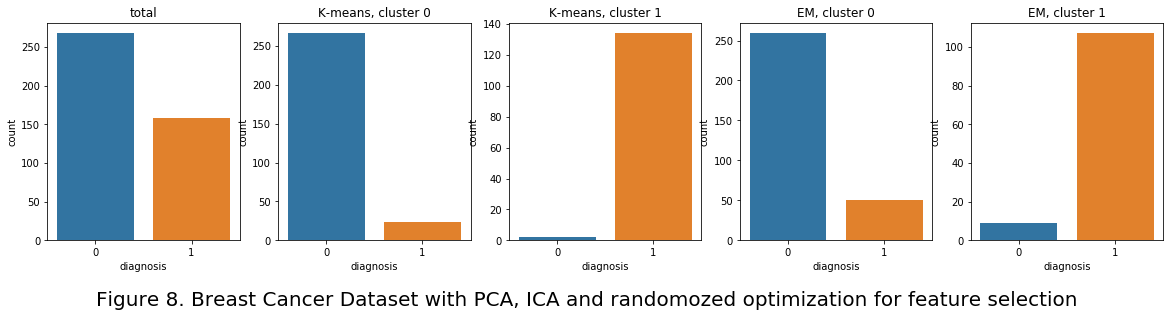

In [15]:
fig, axs = plt.subplots(1,5,figsize=(20,4))
sns.countplot(data=result, x="diagnosis", ax=axs[0]).set_title("total")
sns.countplot(data=cluster0, x="diagnosis", ax=axs[1]).set_title("K-means, cluster 0")
sns.countplot(data=cluster1, x="diagnosis", ax=axs[2]).set_title("K-means, cluster 1")
sns.countplot(data=EMcluster0, x="diagnosis", ax=axs[3]).set_title("EM, cluster 0")
sns.countplot(data=EMcluster1, x="diagnosis", ax=axs[4]).set_title("EM, cluster 1")
fig.suptitle("Figure 8. Breast Cancer Dataset with PCA, ICA and randomozed optimization for feature selection", fontsize=20,y=-0.05)